In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision import models, transforms
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM, GradCAMpp, GradCAM, ScoreCAM
from torchcam.utils import overlay_mask
import matplotlib.image as mpimg

<Figure size 640x480 with 0 Axes>

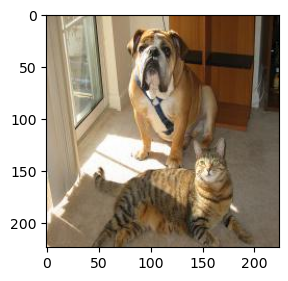

<Figure size 640x480 with 0 Axes>

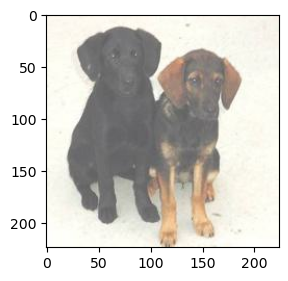

<Figure size 640x480 with 0 Axes>

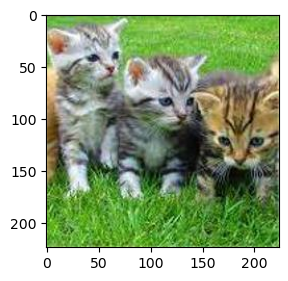

In [83]:
def process(filename: str=None) -> None:

    image = mpimg.imread(filename)
    plt.figure()
    plt.figure(figsize=(3, 13))
    plt.imshow(image)

def process_1(file) -> None:

    plt.figure()
    plt.figure(figsize=(3, 3))
    plt.imshow(file)

def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

for file in ['both.jpg', 'dog.jpg', 'cat.jpg']:
    process(file)

In [84]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [85]:
model = resnet18(pretrained=True).eval()

c:\Users\User\miniconda3\envs\com_vision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\miniconda3\envs\com_vision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [86]:
img = get_image('dog.jpg')
img_t = get_input_tensors(img)
logits = model(img_t)

In [87]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [88]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [89]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

100%|██████████| 1000/1000 [00:07<00:00, 137.12it/s]


<Figure size 640x480 with 0 Axes>

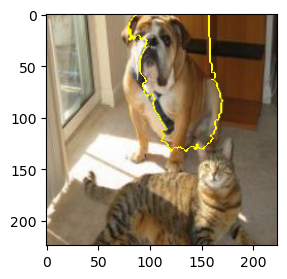

<Figure size 640x480 with 0 Axes>

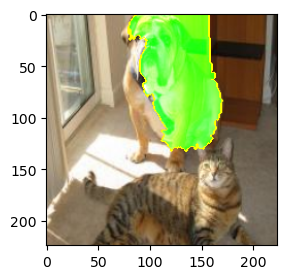

<Figure size 640x480 with 0 Axes>

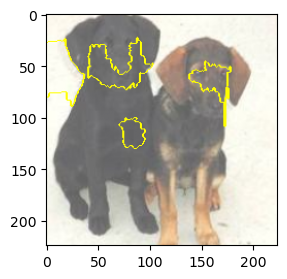

<Figure size 640x480 with 0 Axes>

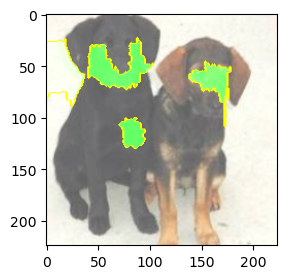

<Figure size 640x480 with 0 Axes>

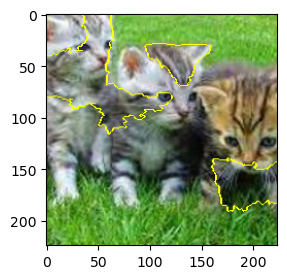

<Figure size 640x480 with 0 Axes>

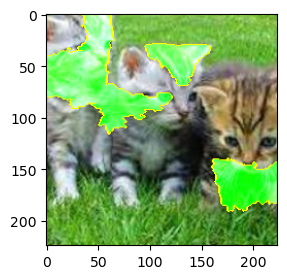

In [90]:
for i in ['both.jpg', 'dog.jpg', 'cat.jpg']:
    img = get_image(i)   
    test_pred = batch_predict([pill_transf(img)])
    test_pred.squeeze().argmax()
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                            batch_predict, # classification function
                                            top_labels=5, 
                                            hide_color=0, 
                                            num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    img_boundry1 = mark_boundaries(temp/255.0, mask)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    for file in [img_boundry1, img_boundry2]:
        process_1(file) #display result images

In [91]:
print(explanation.top_labels[0])

285


100%|██████████| 1000/1000 [00:07<00:00, 137.13it/s]


<Figure size 640x480 with 0 Axes>

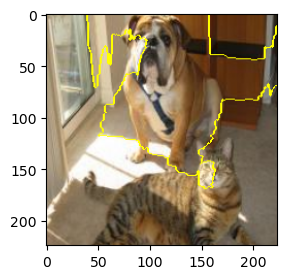

<Figure size 640x480 with 0 Axes>

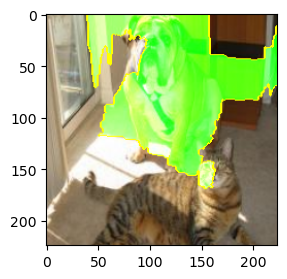

<Figure size 640x480 with 0 Axes>

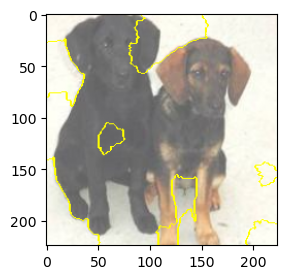

<Figure size 640x480 with 0 Axes>

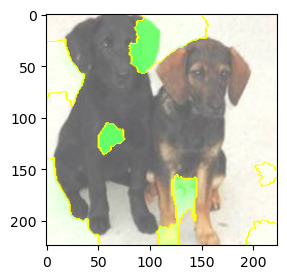

<Figure size 640x480 with 0 Axes>

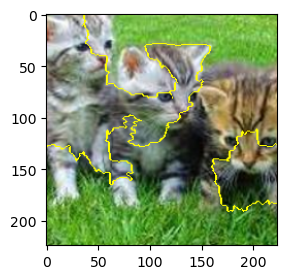

<Figure size 640x480 with 0 Axes>

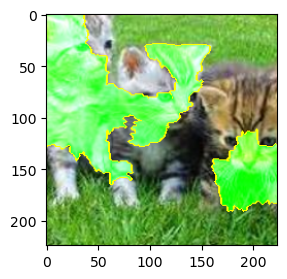

In [92]:
for i in ['both.jpg', 'dog.jpg', 'cat.jpg']:
    img = get_image(i)   
    test_pred = batch_predict([pill_transf(img)])
    test_pred.squeeze().argmax()
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                            batch_predict, # classification function
                                            top_labels=5, 
                                            hide_color=0, 
                                            num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
    img_boundry1 = mark_boundaries(temp/255.0, mask)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    for file in [img_boundry1, img_boundry2]:
        process_1(file) #display result images

100%|██████████| 1000/1000 [00:07<00:00, 131.73it/s]


<Figure size 640x480 with 0 Axes>

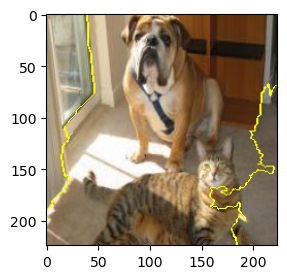

<Figure size 640x480 with 0 Axes>

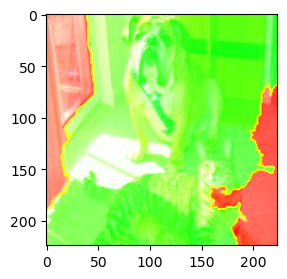

<Figure size 640x480 with 0 Axes>

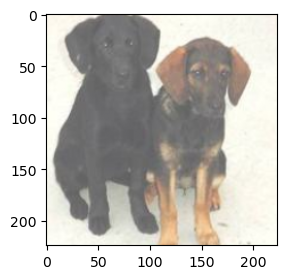

<Figure size 640x480 with 0 Axes>

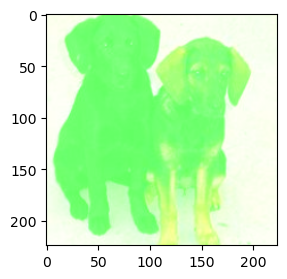

<Figure size 640x480 with 0 Axes>

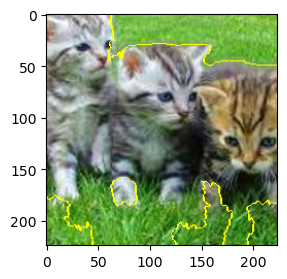

<Figure size 640x480 with 0 Axes>

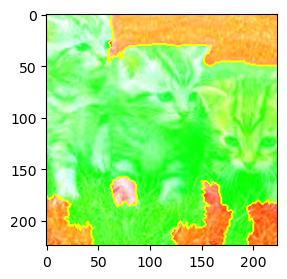

In [93]:
for i in ['both.jpg', 'dog.jpg', 'cat.jpg']:
    img = get_image(i)   
    test_pred = batch_predict([pill_transf(img)])
    test_pred.squeeze().argmax()
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                            batch_predict, # classification function
                                            top_labels=5, 
                                            hide_color=0, 
                                            num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=100, hide_rest=False)
    img_boundry1 = mark_boundaries(temp/255.0, mask)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=100, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    for file in [img_boundry1, img_boundry2]:
        process_1(file) #display result images

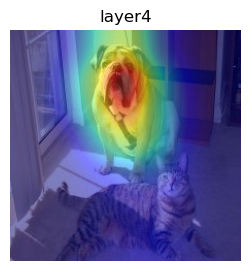

<Figure size 300x300 with 0 Axes>

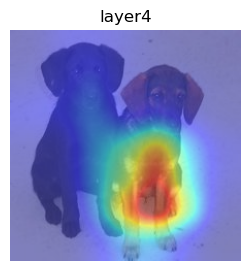

<Figure size 300x300 with 0 Axes>

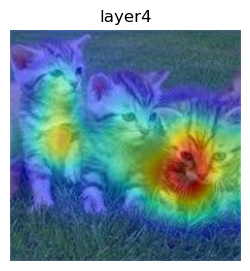

<Figure size 300x300 with 0 Axes>

In [94]:
cam_extractor = GradCAMpp(model)
# Get your input

for image_path in ['both.jpg', 'dog.jpg', 'cat.jpg']:
    img = read_image(image_path)
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0).cuda())
    # Retrieve the CAM by passing the class index and the model output
    cams = cam_extractor(out.squeeze(0).argmax().item(), out)
    for name, cam in zip(cam_extractor.target_names, cams):
        result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
        plt.figure(figsize=(3, 3)); plt.imshow(result); plt.axis('off'); plt.title(name); plt.figure(figsize=(3, 3)); plt.show()

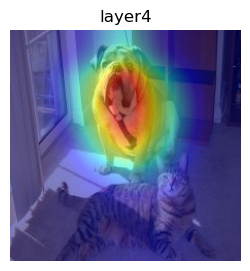

<Figure size 300x300 with 0 Axes>

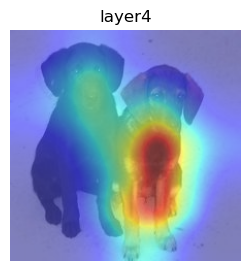

<Figure size 300x300 with 0 Axes>

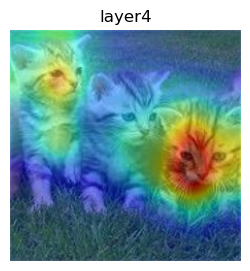

<Figure size 300x300 with 0 Axes>

In [97]:
cam_extractor = ScoreCAM(model)
# Get your input

for image_path in ['both.jpg', 'dog.jpg', 'cat.jpg']:
    img = read_image(image_path)
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0).cuda())
    # Retrieve the CAM by passing the class index and the model output
    cams = cam_extractor(out.squeeze(0).argmax().item(), out)
    for name, cam in zip(cam_extractor.target_names, cams):
        result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
        plt.figure(figsize=(3, 3)); plt.imshow(result); plt.axis('off'); plt.title(name); plt.figure(figsize=(3, 3)); plt.show()

Run this function every time above functions for gradcam++ and scorecam scream with hook error

In [96]:
cam_extractor.remove_hooks()

In [98]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  